In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf, pacf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ..
%ls ./data

/home/den/dev/git/time-series-analysis/final-task
shop_sales.csv  shop_sales_dates.csv  shop_sales_prices.csv


# EDA

## Общий

In [ ]:
sales = pd.read_csv("./data/shop_sales.csv")
dates = pd.read_csv("./data/shop_sales_dates.csv")
prices = pd.read_csv("./data/shop_sales_prices.csv")

In [ ]:
utils.pretty_info(sales, "sales")
utils.pretty_info(dates, "dates")
utils.pretty_info(prices, "prices")

sales:
  Columns: ['item_id', 'store_id', 'date_id', 'cnt']
  Rows: 81855
--------------------------------------------------
dates:
  Columns: ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'date_id', 'CASHBACK_STORE_1', 'CASHBACK_STORE_2', 'CASHBACK_STORE_3']
  Rows: 1819
--------------------------------------------------
prices:
  Columns: ['store_id', 'item_id', 'wm_yr_wk', 'sell_price']
  Rows: 11141
--------------------------------------------------


Далее буду работать с магазином `store_id = STORE_1`.

In [ ]:
sales = sales[sales["store_id"] == "STORE_1"].drop(columns=["store_id"])
dates.drop(columns=["CASHBACK_STORE_2", "CASHBACK_STORE_3"], inplace=True)
prices = prices[prices["store_id"] == "STORE_1"].drop(columns=["store_id"])

In [ ]:
utils.pretty_info(sales, "sales")
utils.pretty_info(dates, "dates")
utils.pretty_info(prices, "prices")

sales:
  Columns: ['item_id', 'date_id', 'cnt']
  Rows: 27285
--------------------------------------------------
dates:
  Columns: ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'date_id', 'CASHBACK_STORE_1']
  Rows: 1819
--------------------------------------------------
prices:
  Columns: ['item_id', 'wm_yr_wk', 'sell_price']
  Rows: 3873
--------------------------------------------------


### Анализ sales

In [ ]:
unique_items = sales["item_id"].unique()
n_items = len(unique_items)
print(f"Number of unique items: {n_items}")

Number of unique items: 15


In [ ]:
for item in unique_items:
    item_sales = sales[sales["item_id"] == item]
    first_date = item_sales["date_id"].min()
    last_date = item_sales["date_id"].max()
    print(f"{item}: first date_id = {first_date}, last date_id = {last_date}")

STORE_1_064: first date_id = 1, last date_id = 1819
STORE_1_065: first date_id = 1, last date_id = 1819
STORE_1_325: first date_id = 1, last date_id = 1819
STORE_1_376: first date_id = 1, last date_id = 1819
STORE_1_090: first date_id = 1, last date_id = 1819
STORE_1_252: first date_id = 1, last date_id = 1819
STORE_1_339: first date_id = 1, last date_id = 1819
STORE_1_546: first date_id = 1, last date_id = 1819
STORE_1_547: first date_id = 1, last date_id = 1819
STORE_1_555: first date_id = 1, last date_id = 1819
STORE_1_584: first date_id = 1, last date_id = 1819
STORE_1_586: first date_id = 1, last date_id = 1819
STORE_1_587: first date_id = 1, last date_id = 1819
STORE_1_714: first date_id = 1, last date_id = 1819
STORE_1_727: first date_id = 1, last date_id = 1819


У нас по-дневные данные продаж в `sales`.  
Для всех товаров временной диапазон продаж одинаков - это хорошо. 

In [ ]:
n_days = sales["date_id"].max() - sales["date_id"].min() + 1
print(f"Number of days in sales data: {n_days}")
n_weeks = n_days / 7
n_months = n_days / 30
n_quarters = n_days / (4 * 30)
n_years = n_days / 365
print(f"Number of weeks in sales data: {n_weeks}")
print(f"Number of months in sales data: {n_months}")
print(f"Number of quarters in sales data: {n_quarters}")
print(f"Number of years in sales data: {n_years}")

Number of days in sales data: 1819
Number of weeks in sales data: 259.85714285714283
Number of months in sales data: 60.63333333333333
Number of quarters in sales data: 15.158333333333333
Number of years in sales data: 4.983561643835617


Временной диапазон длительный (почти 5 лет). Поэтому по идее мы даже сможем захватить годовую сезонность (так как для "захвата" сезонности требуется, чтобы было хотя бы 2 периода в train сплите).

План по сплиту данных: 
* train: фиксированно возьмем 2 года - сразу до val сплита
* val: пред-последний 1 год - чтобы валидировать работу модели на разных месяцах
* test: последние 4 месяца (квартал) - построим прогноз на последнюю неделю, месяц, квартал

Для классических статистических моделей (EMA, SARIMA, SARIMAX) будем использовать time-series cross-validation с forecast horizon = 1 day и с шагом в 15 дней. Таким образом у нас получится 25 train-val сплитов для оценки модели. В идеале бы взять все 365 сплитов, однако CV в таком случае будет очень долго идти.

Валидируем классические статистические модели на прогнозе в 1 день, а не на неделю, месяц, квартал (промежутки прогноза на test), так как большинство из них строят прогноз по принципу рекуррентного предсказания: для горизонта >1 день следующий прогноз строится на основе предыдущего предсказанного значения, что может приводить к накоплению ошибки. Поэтому параметры модели обычно подбираются по однодневному горизонту, а для более длинных горизонтов используется последовательное прогнозирование.

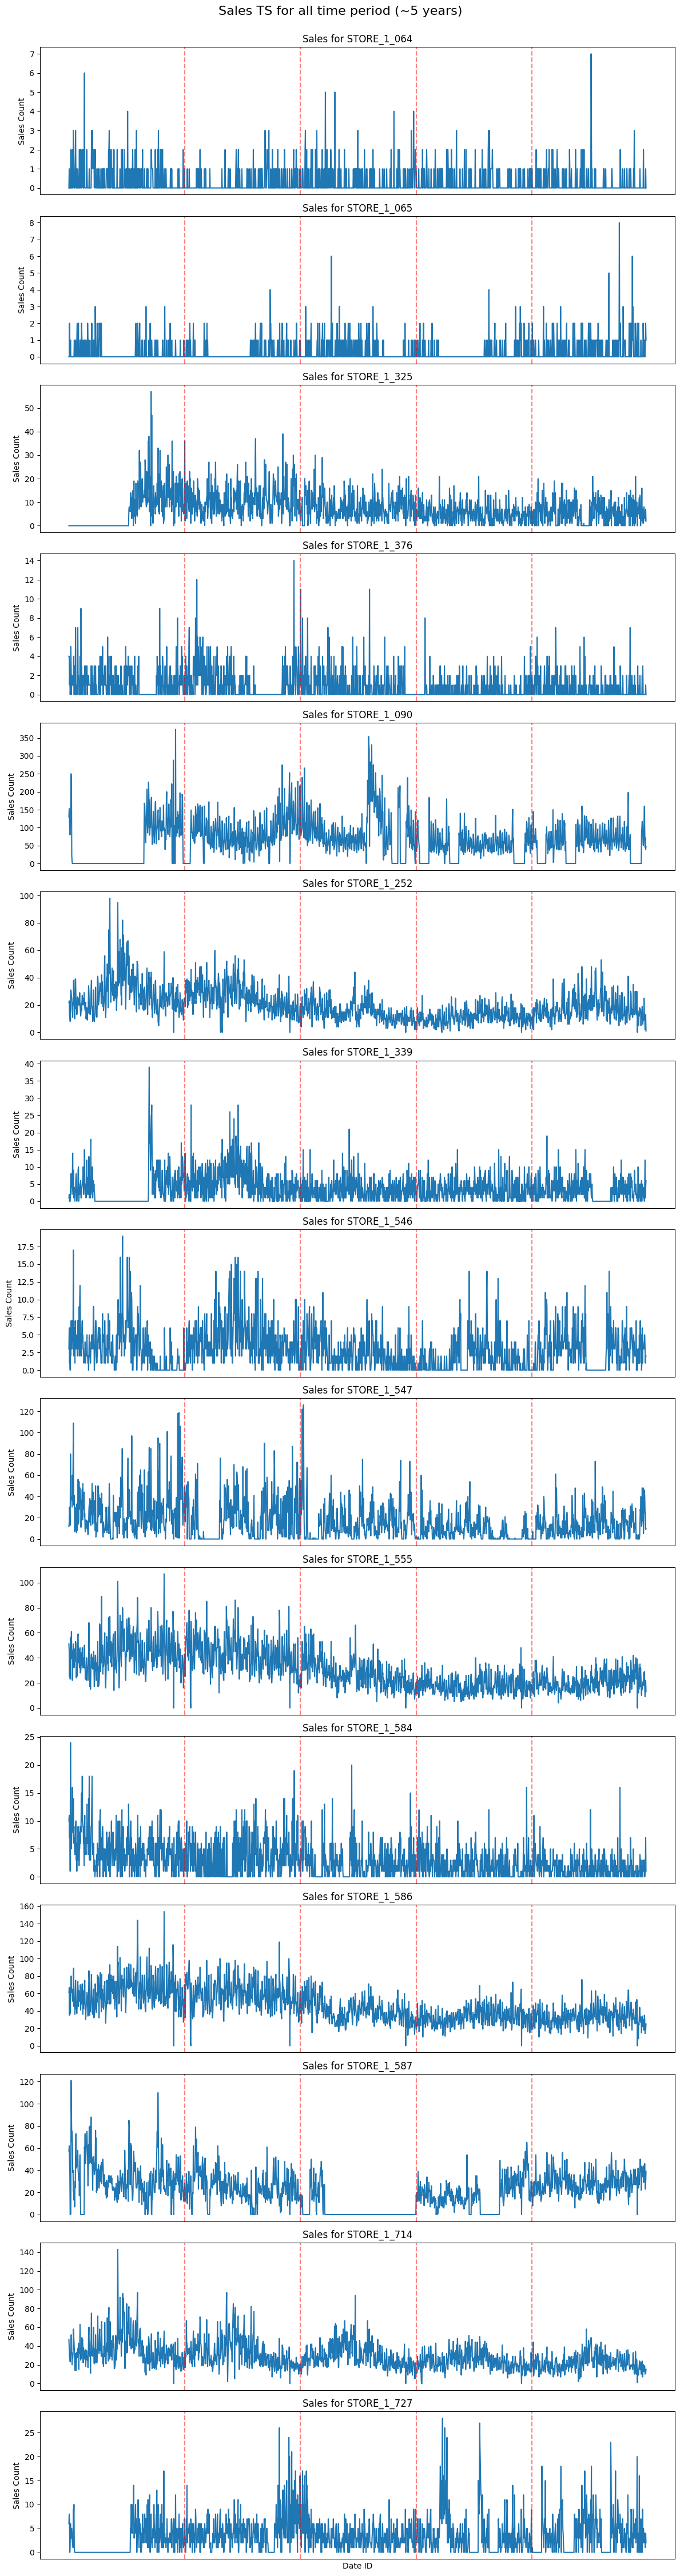

In [ ]:
fig, axes = plt.subplots(n_items, 1, figsize=(12, 3 * n_items), sharex=True)

for ax, item in zip(axes, unique_items):
    item_sales = sales[sales["item_id"] == item]
    ax.plot(item_sales["date_id"], item_sales["cnt"])

    # Draw vertical lines at each 365 date_id
    for year in range(365, n_days + 1, 365):
        ax.axvline(x=year, color="red", linestyle="--", alpha=0.5)

    ax.set_title(f"Sales for {item}")
    ax.set_ylabel("Sales Count")
    ax.set_xticks([])

fig.suptitle("Sales TS for all time period (~5 years)", fontsize=16, y=1)
axes[-1].set_xlabel("Date ID")
plt.tight_layout()
plt.show()

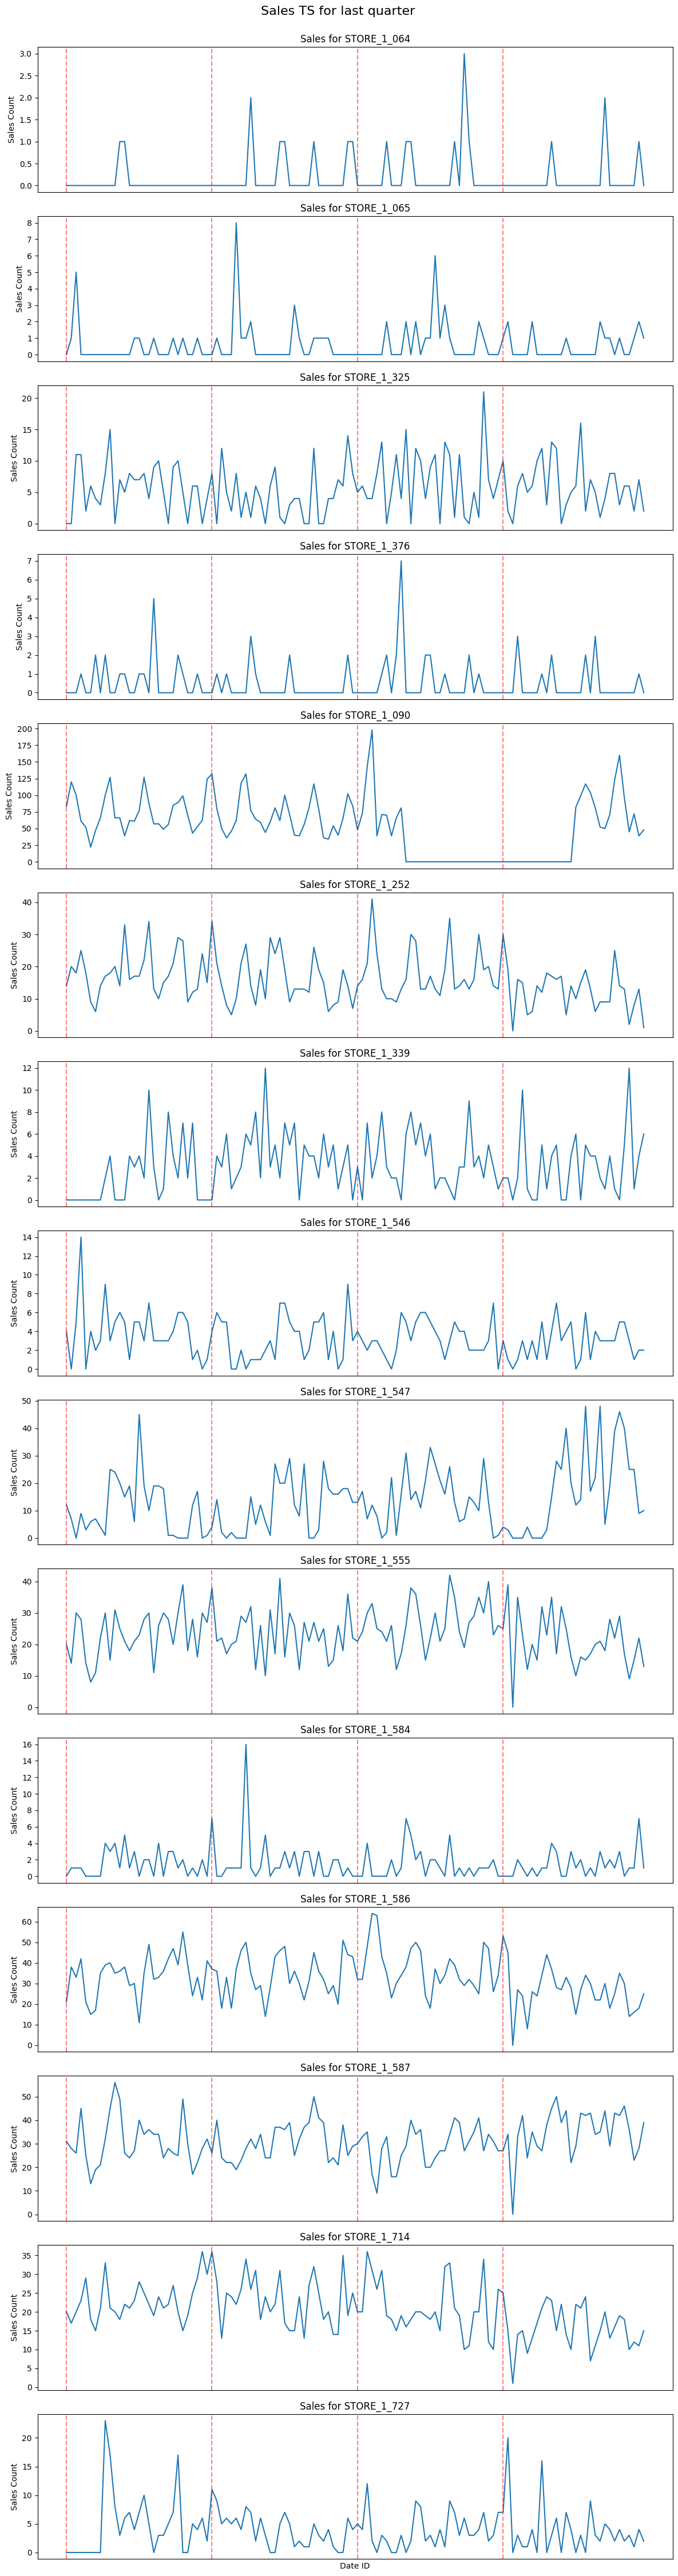

In [ ]:
fig, axes = plt.subplots(n_items, 1, figsize=(12, 3 * n_items), sharex=True)

for ax, item in zip(axes, unique_items):
    item_sales = sales[sales["item_id"] == item][-120:]  # Last quarter
    ax.plot(item_sales["date_id"], item_sales["cnt"])

    # Draw vertical lines at each 30 date_id
    min_date = item_sales["date_id"].min()
    max_date = item_sales["date_id"].max()
    for d in range(min_date, max_date + 1, 30):
        ax.axvline(x=d, color="red", linestyle="--", alpha=0.5)

    ax.set_title(f"Sales for {item}")
    ax.set_ylabel("Sales Count")
    ax.set_xticks([])

fig.suptitle("Sales TS for last quarter", fontsize=16, y=1)
axes[-1].set_xlabel("Date ID")
plt.tight_layout()
plt.show()

Наблюдения:
* в каждом ВР хорошо наблюдаются частые периодические пики продаж (предполагаю, что это недельные сезонности - на выходных спрос больше)
* почти в каждом ВР есть отрезки с нулевыми продажами. Как краткосрочные (товар действительно покупают не каждый день), так и долгосрочные (возможно товар закончился/проблемы с поставкой)
* у некоторых ВР отсутствует выраженный долгосрочный тренд продаж (064), а у некоторых присутствует (252)
* часто наблюдаются вплески продаж (как однодневные, так и довольно продолжительные (2-3 недели)), однако называть это аномалиями не хочется, так как предполагаю, что это может быть причиной праздников (данные по которым у нас есть)
* среди 15 товаров есть как популярные (090 - покупают в среднем по 150 раз в день), так и довольно редкие (064 - 1 продажа в день)

### Анализ dates

In [ ]:
dates.head()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,1,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,2,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,3,0
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,4,0
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,5,1


In [ ]:
dates["date"] = pd.to_datetime(dates["date"])

In [ ]:
cashback_store_1 = dates[dates["CASHBACK_STORE_1"] == 1]
print(f"Number of days with cashback in STORE_1: {len(cashback_store_1)}")

Number of days with cashback in STORE_1: 600


In [ ]:
num_days_one_event = dates["event_name_1"].notna().sum()
num_days_two_events = (dates["event_name_1"].notna() & dates["event_name_2"].notna()).sum()

print(f"Number of days with one event: {num_days_one_event}")
print(f"Number of days with two events: {num_days_two_events}")

Number of days with one event: 146
Number of days with two events: 4


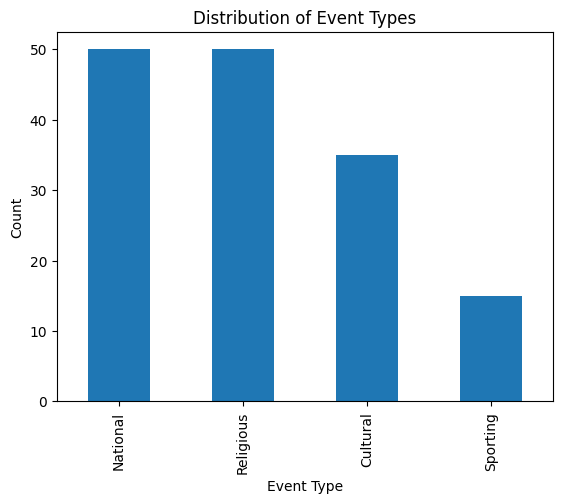

In [ ]:
event_types = pd.concat([dates["event_type_1"], dates["event_type_2"]])
event_types = event_types.dropna()

event_types.value_counts().plot(kind="bar")
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

In [ ]:
# Concat sales and dates
sales_dates = pd.merge(sales, dates, on="date_id", how="left")
utils.pretty_info(sales_dates, "sales_dates")

sales_dates:
  Columns: ['item_id', 'date_id', 'cnt', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'CASHBACK_STORE_1']
  Rows: 27285
--------------------------------------------------


In [ ]:
sales_dates.head()

,item_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK_STORE_1
0,STORE_1_064,1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,STORE_1_064,2,1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0
2,STORE_1_064,3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0
3,STORE_1_064,4,0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,0
4,STORE_1_064,5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1


### Анализ prices

In [ ]:
prices.head()

,item_id,wm_yr_wk,sell_price
22,STORE_1_064,11101,2.54
23,STORE_1_065,11101,2.94
24,STORE_1_376,11101,1.98
25,STORE_1_090,11101,1.25
26,STORE_1_252,11101,1.48


In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3873 entries, 22 to 11140
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     3873 non-null   object 
 1   wm_yr_wk    3873 non-null   int64  
 2   sell_price  3873 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.0+ KB


Цены указаны для каждой недели:

In [ ]:
for item_id in unique_items:
    print(item_id, len(sales_dates[sales_dates["item_id"] == item_id]), len(prices[prices["item_id"] == item_id]) * 7)

STORE_1_064 1819 1820
STORE_1_065 1819 1820
STORE_1_325 1819 1631
STORE_1_376 1819 1820
STORE_1_090 1819 1820
STORE_1_252 1819 1820
STORE_1_339 1819 1820
STORE_1_546 1819 1820
STORE_1_547 1819 1820
STORE_1_555 1819 1820
STORE_1_584 1819 1820
STORE_1_586 1819 1820
STORE_1_587 1819 1820
STORE_1_714 1819 1820
STORE_1_727 1819 1820


Для товара STORE_1_325 пропущено 189 / 7 = 27 недель с ценами. 

In [ ]:
# Concat prices and sales_dates
sales_dates_prices = pd.merge(sales_dates, prices, on=["wm_yr_wk", "item_id"], how="left")
utils.pretty_info(sales_dates_prices, "sales_dates_prices")

sales_dates_prices:
  Columns: ['item_id', 'date_id', 'cnt', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'CASHBACK_STORE_1', 'sell_price']
  Rows: 27285
--------------------------------------------------


In [ ]:
sales_dates_prices.head()

,item_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK_STORE_1,sell_price
0,STORE_1_064,1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,2.54
1,STORE_1_064,2,1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,2.54
2,STORE_1_064,3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,2.54
3,STORE_1_064,4,0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,0,2.54
4,STORE_1_064,5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,2.54


In [ ]:
sales_dates_prices["sell_price"].isna().sum()

189

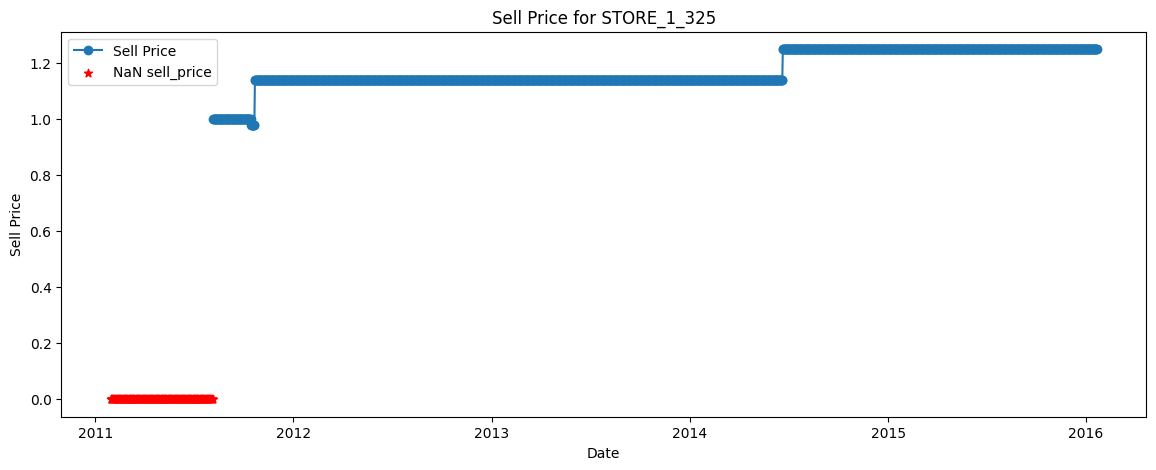

In [ ]:
item_id = "STORE_1_325"
item_data = sales_dates_prices[sales_dates_prices["item_id"] == item_id]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(item_data["date"], item_data["sell_price"], label="Sell Price", marker="o", linestyle="-")

nan_mask = item_data["sell_price"].isna()
ax.scatter(item_data.loc[nan_mask, "date"], [0] * nan_mask.sum(), marker="*", color="red", label="NaN sell_price")

ax.set_title(f"Sell Price for {item_id}")
ax.set_xlabel("Date")
ax.set_ylabel("Sell Price")
ax.legend()
plt.show()

Не проблема, что есть NaN, так как такие старые значения мы не будем использовать (отсечка будет с date_id: 1819 - 120 (test) - 365 * 3 (train/val) = 604)

### Отсечка данных

In [ ]:
sales_dates_prices.head()

,item_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK_STORE_1,sell_price
0,STORE_1_064,1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,2.54
1,STORE_1_064,2,1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,2.54
2,STORE_1_064,3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,2.54
3,STORE_1_064,4,0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,0,2.54
4,STORE_1_064,5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,2.54


In [ ]:
# Как было и описано выше, обрежем слишком старые данные
test_size = 120  # Last quarter
train_val_size = 365 * 3  # 2 + 1 years for train and validation

sales_dates_prices = sales_dates_prices[
    sales_dates_prices["date_id"] >= sales_dates_prices["date_id"].max() - test_size - train_val_size
]
sales_dates_prices = sales_dates_prices.reset_index(drop=True)

sales_dates_prices["date"].min(), sales_dates_prices["date"].max()

(Timestamp('2012-09-23 00:00:00'), Timestamp('2016-01-21 00:00:00'))

## По каждому товару

В этой секции проанализирую ВР каждого товара на предмет тренда, сезонности, автокорреляций.

In [ ]:
# Тут уже возьмем только train и validation часть (чтобы не было утечки в тест)
sales_dates_prices = sales_dates_prices[
    sales_dates_prices["date_id"] < sales_dates_prices["date_id"].max() - test_size
]
sales_dates_prices["date"].min(), sales_dates_prices["date"].max()

(Timestamp('2012-09-23 00:00:00'), Timestamp('2015-09-22 00:00:00'))

### Item 064

In [ ]:
item_id = "STORE_1_064"

item_data = sales_dates_prices[sales_dates_prices["item_id"] == item_id]

In [ ]:
item_data.head()

,item_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK_STORE_1,sell_price
0,STORE_1_064,604,0,2012-09-23,11235,Sunday,2,9,2012,NaN,NaN,NaN,NaN,0,2.54
1,STORE_1_064,605,1,2012-09-24,11235,Monday,3,9,2012,NaN,NaN,NaN,NaN,0,2.54
2,STORE_1_064,606,0,2012-09-25,11235,Tuesday,4,9,2012,NaN,NaN,NaN,NaN,0,2.54
3,STORE_1_064,607,1,2012-09-26,11235,Wednesday,5,9,2012,NaN,NaN,NaN,NaN,0,2.54
4,STORE_1_064,608,0,2012-09-27,11235,Thursday,6,9,2012,NaN,NaN,NaN,NaN,0,2.54


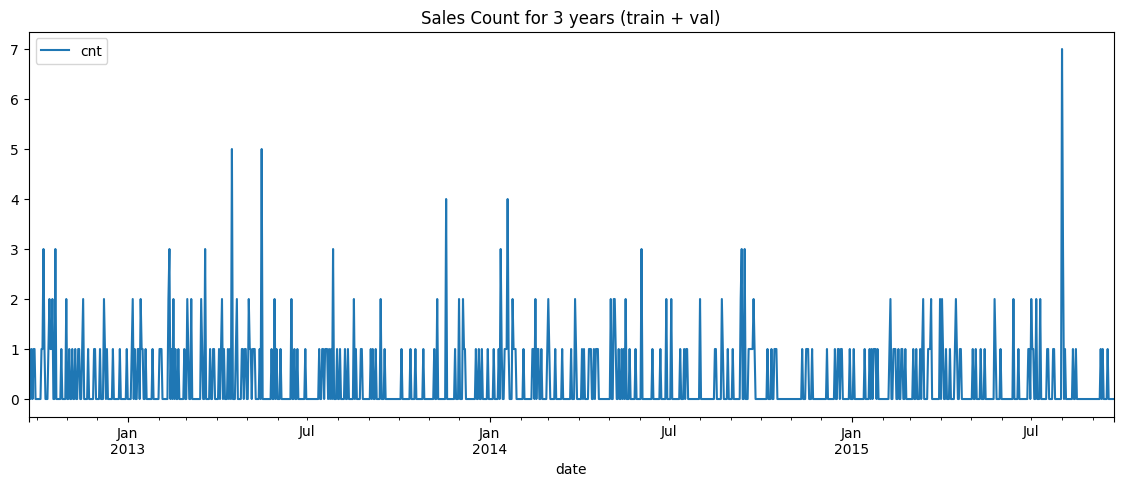

In [ ]:
item_data.plot(x="date", y="cnt", figsize=(14, 5), title="Sales Count for 3 years (train + val)")

Видим слабый нисходящий тренд.

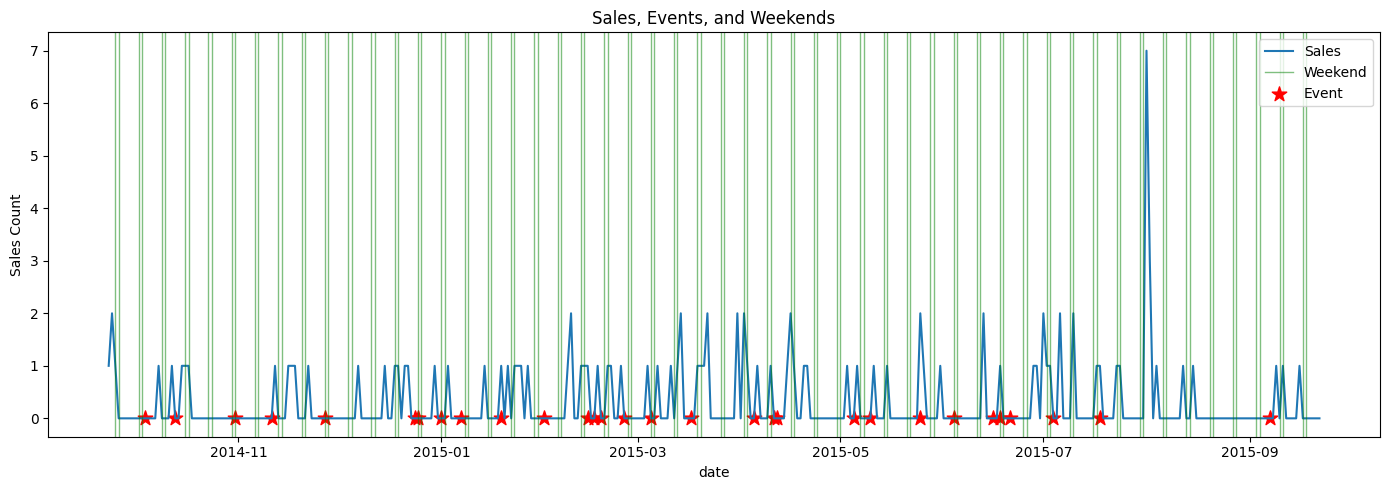

In [ ]:
# Sales for last 365 days (with weekends and events)
utils.plot_item_features(item_data[-365:])

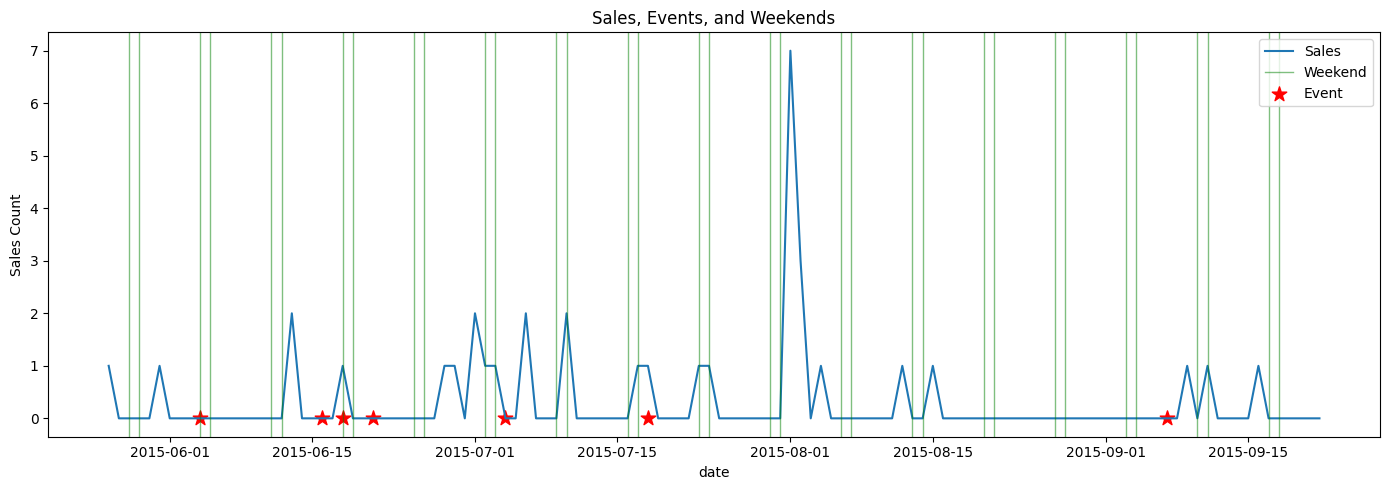

In [ ]:
# Sales for last quater (with weekends and events)
utils.plot_item_features(item_data[-120:])

Сезонности не наблюдается.  
Корреляции продаж с днем недели сложно определить.  

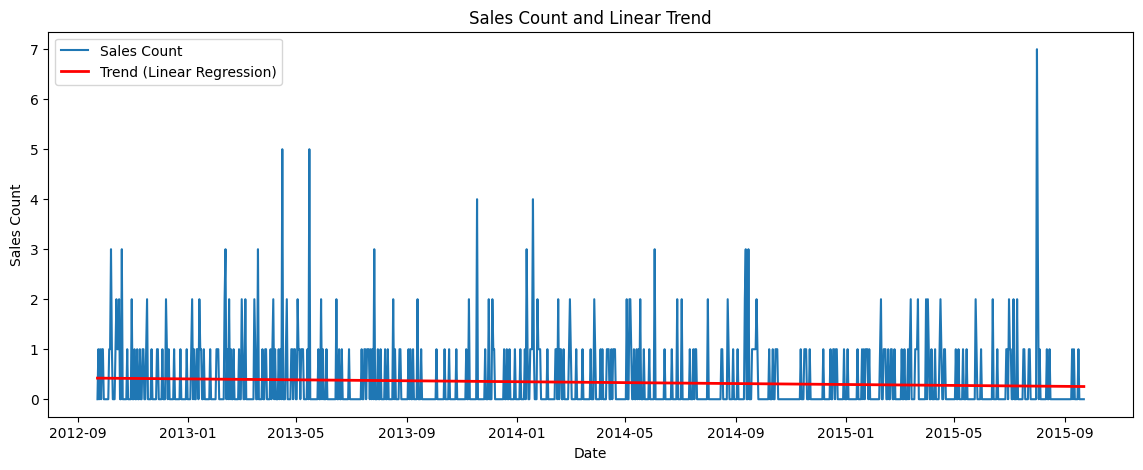

In [ ]:
# Обучим простейшую линейную регрессию из sklearn на продажах и построим как линейный тренд
utils.plot_linear_trend(item_data)

In [ ]:
utils.test_trend(item_data["cnt"])

(True, {'KPSS': 0.0363253004050241, 'ADF': 0.0})

По критерию KPSS мы отвергаем гипотезу "ряд стационарен", а по критерию ADF наоборот отвергаем гипотезу "ряд нестационарен". Поэтому, чтобы избавиться от тренда, применим дифференцирование (1 лаг).

In [ ]:
item_data.loc[:, "diff1"] = item_data["cnt"] - item_data["cnt"].shift(1)

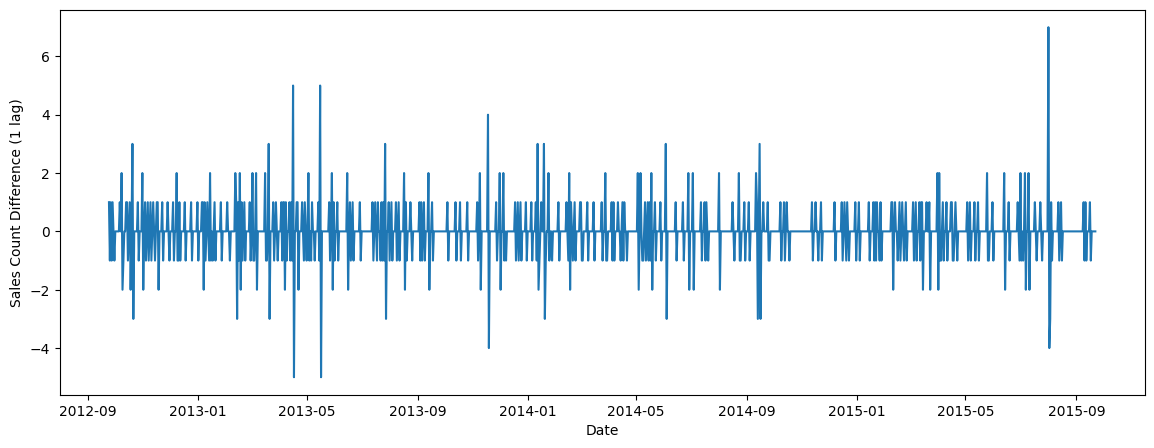

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 5)
ax.plot(item_data.date, item_data.diff1)
ax.set_xlabel("Date")
ax.set_ylabel("Sales Count Difference (1 lag)")

In [ ]:
utils.test_trend(item_data.diff1.dropna())

<string>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



(False, {'KPSS': 0.1, 'ADF': 3.0524683457314216e-19})

Теперь статистические тесты указывают на то, что ряд стационарен.

Построим графики ACF и PACF для этого стационарного ряда.

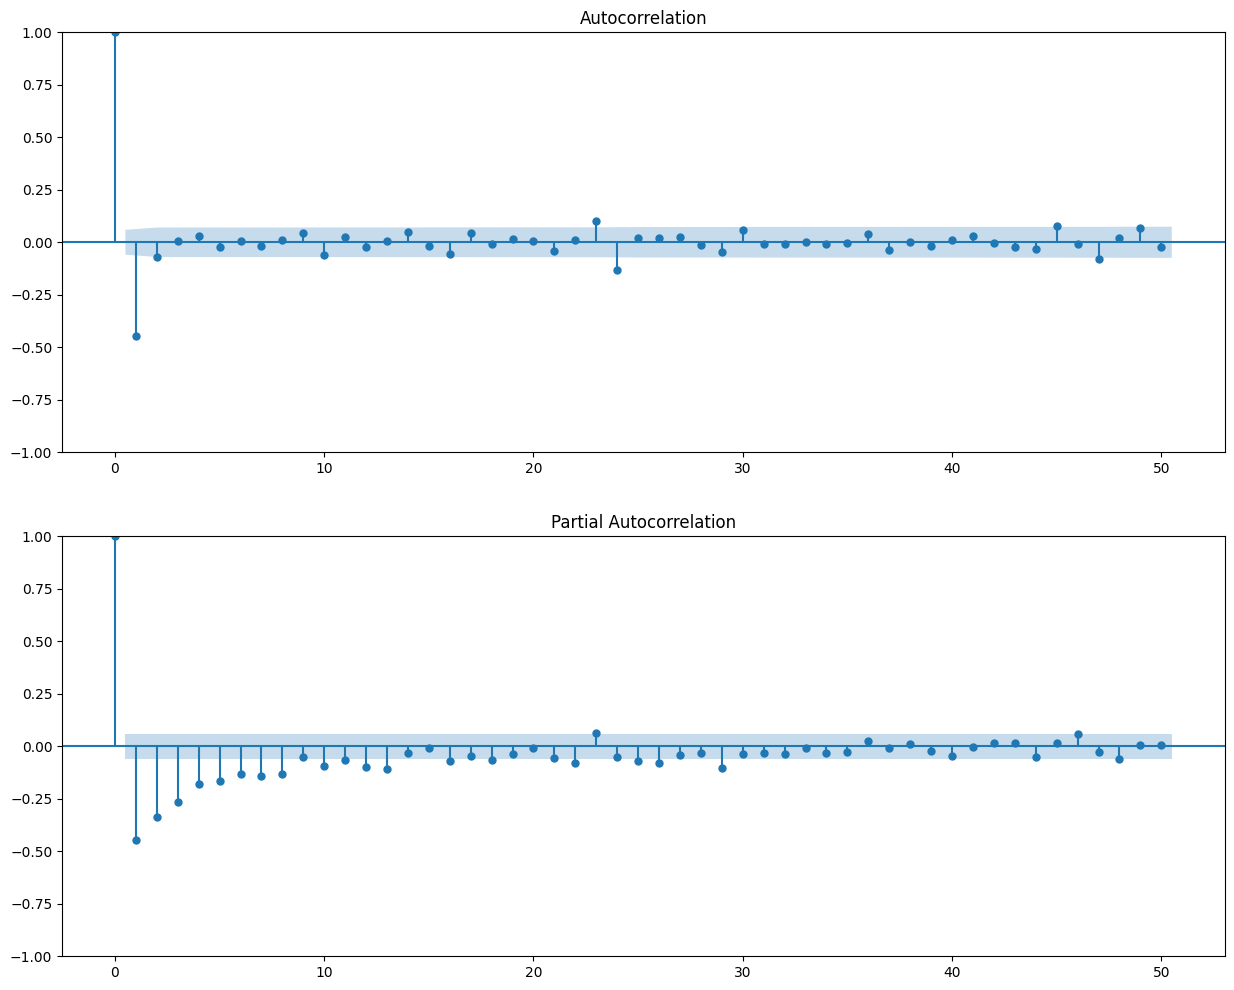

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
tsaplots.plot_acf(item_data.diff1.dropna(), ax=ax[0], lags=50)
tsaplots.plot_pacf(item_data.diff1.dropna(), ax=ax[1], lags=50)

In [ ]:
# Получим точные значения ACF и PACF с доверительными интервалами
acf_vals, acf_confint = acf(item_data.diff1.dropna(), nlags=500, alpha=0.05)
pacf_vals, pacf_confint = pacf(item_data.diff1.dropna(), nlags=500, alpha=0.05, method="ywm")

significant_acf_lags = [lag for lag, (low, high) in enumerate(acf_confint) if low > 0 or high < 0]
significant_pacf_lags = [lag for lag, (low, high) in enumerate(pacf_confint) if low > 0 or high < 0]

print("Significant ACF lags:", significant_acf_lags)
print("Significant PACF lags:", significant_pacf_lags)

Significant ACF lags: [0, 1, 2, 23, 24, 45, 47, 87, 134, 150, 187, 196]
Significant PACF lags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 18, 22, 23, 25, 26, 29, 48, 86, 89, 90, 115, 149, 195, 197, 288]


Большое кол-во статзначимых лагов в ACF и PACF говорит о том, что значения ряда имеют много зависимостей от предыдущих значений.

Также эти рассчитанные лаги будут нужны нам для определения оптимальных гиперпараметров AR и MA частей моделей SARIMA(X).

### Item 065

### Item 325

### Item 376

### Item 090

### Item 252

### Item 339

### Item 546

### Item 547

### Item 555

### Item 584

### Item 586

### Item 587

### Item 714

### Item 727